# Network data analysis

Most geospatial data is represented in one of two spatial models, **vector-based**, i.e. points, lines and polygons, or **raster-based**, i.e. cells of a continuous grid surface. The vector data model is **feature-oriented**, as it represents space as a series of discrete entities.

Analyzing precisely defined paths, such as roads and rivers or drainage canals, i.e. discrete entities that derive mainly from the built environment, and where attributes play a major role in determining the network.

A network is based much more on the interaction of its component entities than it is based on its component locations. 

But in the real-world networks, such as a road system, must be modelled appropriately to fit into the different spatial models.

https://husdal.com/1999/10/11/network-analysis-raster-versus-vector-a-comparison-study/

Almost everyone has needed a type of network analysis in their life.

For example:

What’s the shortest route to the beach?
Where should I build a hospital to best serve a community?
How can I optimize a vehicle delivery fleet?

## Point-to-point analysis

A point-to-point analysis is the most common routing problem. It consists of a set of points to find the most optimal route based on specific criteria.

Find Nearest – Where is the closest destination? It finds the nearest destination based on a starting point with multiple potential destinations.

Shortest Distance – What’s the fastest route? This analysis accumulates all distances, as you travel out from one point to the other. Then, it finds the route with the least distance.

Fastest route – Which route takes the least amount of time? This network analysis takes into account speed limits, road classification, and other costs to determine the least travel time.

Other types of point-to-point analysis include the most eco-friendly, scenic, and winding routes. Each type of network analysis generates directions from origin to destination.

It can also include the capability to select the mode of travel such as emergency vehicles, trucks, pedestrians, transit, or cycling.

```{image} images/shortest_route.png
:width: 600px
:align: center
```

## Finding coverage

In this type of network analysis, drive-time areas correspond to the distance that can be reached within a specific amount of time.

Service Areas – Which houses are within 5, 10, and 15 minutes from a fire station? This type of network analysis also can understand where businesses cover and if there are any gaps.

Drive-time areas are different from buffers because it takes into account a street network. Buffers can cross water bodies but drive-time areas can only cross water when there’s a bridge.

```{image} images/service_areas.png
:width: 600px
:align: center
```

## Optimize fleet

This tool is ideal when your main goal is to service a set of orders in the traveling salesperson problem. Also, you can best minimize the overall operating cost, by managing sets of vehicles and drivers.

Optimize Fleet – The purpose of this network analysis tool is to find the most efficient route for delivery, repair, transit, or any type of fleet service.

For example, a furniture company might want to use several trucks to deliver furniture to homes. Alternatively, a fleet might want to schedule their weekly visits, including all the logistics.

```{image} images/optimize_fleet.png
:width: 600px
:align: center
```

## Select optimal site

Optimal site selection takes into account the demand to locate the best location given several facilities. For example, it can help decide where to build new hospitals depending on existing hospitals and the available demand.

Location-allocation – This network analysis tool helps business owners pinpoint optimal location for their store. It can also compare with competing stores to target market share.

```{image} images/optimize_sites.png
:width: 600px
:align: center
```

In this lecture we will use the Python library `OSMnx` to download data from **OpenStreetMap (OSM)** and format it into a **graph** model. We will then use the `NetworkX` library to conduct network analysis. 

* Cafe data from OSM

* Which is the closest cafe?

* How many cafes can we walk to in 15 minutes?

* How do we sample the 10 nearest cafes in the shortest distance?

* Where should a new cafe be built?

Euclidean distances often underestimate the distance between two objects, especially when there are obstacles between the two. So we will now compute some more realistic distances to cafes around Condon Hall. 

In [3]:
import numpy as np
import geopandas as gpd

import osmnx as ox
import networkx as nx

from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import LineString, MultiLineString

import folium

## Retrieve OSM data

First we will retrieve all features labelled (or tagged) as **buildings** in Eugene from OSM. Don't worry if you're not familiar with OSM or `OSMnx`, we will cover this topic next week in our data access lecture. 

In [4]:
# Specify type of data
tags = {'building': True}

# Download building geometries from OSM
gdf = ox.geometries_from_place('Eugene, Oregon, USA', tags)

/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


This produces a large `GeoDataFrame` containing over 56,000 buildings. 

In [5]:
print(gdf.shape)

(56025, 246)


For the purposes of this assignment, we are only interested in buildings that are tagged as **cafes**. Cafes are usually tagged as an **amenity** in OSM so we can filter them using a string comparison.

In [6]:
# Filter cafes
cafes = gdf[gdf['amenity'] == 'cafe'].reset_index()
print(cafes.shape)

(35, 248)


We find that there are 35 cafes in Eugene. This could well be an underestimate since there could be cafes that were not tagged as amenities when mapped. But let's keep moving forward and plot them. 

The cafes are acually **polygons** so we will compute their **centroids** to make it simpler to plot. 

In [7]:
# Get cafe centroids
cafes['centroid'] = cafes['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

We can visulize interactively using `folium`. Again don't be too worried if you haven't used this library, we will cover it in a future lecture.

In [8]:
# Define center of map (i.e. Condon Hall) and initial zoom level
lat_lon = [44.0751, -123.0781]
m = folium.Map(location=lat_lon, zoom_start=12)

for i in range(0, cafes.shape[0]):
    my_string = cafes.iloc[i]['name']
    folium.Marker([cafes.iloc[i]['centroid'].y, cafes.iloc[i]['centroid'].x],
                 popup=my_string).add_to(m)

# Display map
m

## Produce a network

We will now produce a network using roads, sidewalks, and trails features in OSM. The [`graph`](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.graph) module in `OSMnx` automatically process a network topology from raw OpenStreetMap data. 

```{note}
A **network** is also known as a **graph** in mathematics.
```

We will use the `graph_from_point` function which accepts a **point** (as lat/lon), a **distance** (in meters), and a **network type**. The options for **network type** are available in [documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_point) and include `"all_private"`, `"all"`, `"bike"`, `"drive"`, `"drive_service"`, `"walk"`. We choose a distance of **2 miles** and the `walk` option since we are interested in cafes that are walkable. 

In [9]:
# Define coordinates of Condon Hall
lat_lon = (44.0451, -123.0781)

# Define walkable street network 3.2 km around Condon Hall
g = ox.graph_from_point(lat_lon, dist=3200, network_type='walk')

Let's see what the graph looks like...

/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


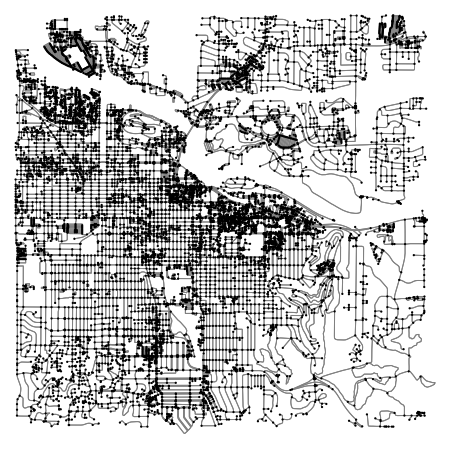

In [10]:
# Plot map
fig, ax = ox.plot_graph(g, bgcolor='white', node_color='black', edge_color='grey', node_size=5)

The first thing to note is that th network structure consists of **nodes** and **edges**. Nodes represent objects while edges represent the relationship between those objects.

Since our network represents transport infrastructure, nodes represent intersections/dead-ends and edges represent the street segments that link them. If we were studying social relationships between Facebook users, nodes would represent users and edges would represent relationships between them (e.g. friendships or group memberships). 

Also note that the graph is `MultiDiGraph`, meaning that bidirectional streets are represented with two edges (with identical geometries): one from node 1 to node 2 and another from 2 to 1, to represent both possible directions of flow. 

In [11]:
g

Once we have produced our **graph** or **network**, it is good practice to reproject it to UTM coorindates so we can work in SI units (i.e. meters) instead of degrees. The [`graph_project`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_graph) function can be used to reproject the graph. The docs note that if the `to_crs` argument is set to `None`, the graph is projected to the UTM coordinate system for the UTM zone in which the graph's centroid lies. 

In [12]:
# Convert to graph
graph_proj = ox.project_graph(g, to_crs=None)

## Define points of interest

Next we define the centroid locations of Condon Hall and our cafes, making sure that they are in the same projection as our graph (i.e. UTM Zone 10N or EPSG:32610). 

We can find Condon Hall in our original OSM building data using string matching. 

In [13]:
# Get coordinates of Condon Hall
condon_hall = gdf[gdf['name'] == 'Condon Hall'].reset_index()

# Reproject to UTM Zone 10N
condon_hall = condon_hall.to_crs('EPSG:32610')
cafes = cafes.to_crs('EPSG:32610')

Compute centroids...

In [14]:
condon_hall['centroid'] = condon_hall['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

cafes['centroid'] = cafes['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

Format the centroids as a **list**

```{note}
To begin with we will only compute the shortest distance between Condon Hall and the **first** cafe in our `GeoDataFrame`.
```

In [15]:
# Get x and y coordinates of Condon Hall
orig_xy = [condon_hall['centroid'].y.values[0], condon_hall['centroid'].x.values[0]]

# Get x and y coordinates of the first cafe
target_xy = [cafes['centroid'].y.values[0], cafes['centroid'].x.values[0]]

## Find the shortest path between points

The [`distance`](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.distance) module in `OSMnx` contains functions for calculating distances, shortest paths, and finding nearest node/edge(s) to point(s). Since the coordinates of our points are unlikely to exactly align with one of the nodes, we first have to find the nearest node to our points using the `nearest_nodes` function. 

In [16]:
# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node = ox.distance.nearest_nodes(G=graph_proj, X=orig_xy[1], Y=orig_xy[0], return_dist=False)

# Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)

Now we can finally compute the shortest distance between our two points using the [`shortest_path`](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html) functions available from `NetworkX`. The [`shortest_path`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html#networkx.algorithms.shortest_paths.generic.shortest_path) function returns a list of nodes along the shortest path, and the [`shortest_path_length`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path_length.html#networkx.algorithms.shortest_paths.generic.shortest_path_length) function returns the length of this path.

```{note}
The `weight` argument defines the edge attribute to minimize when solving shortest path. In our case, we would like the **shortest distance** so we choose `length`. 
```

In [17]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')
length = nx.shortest_path_length(G=graph_proj, source=orig_node, target=target_node, weight='length')

In [18]:
print("Shortest path distance = {t:.1f} km.".format(t=length/1000))

Shortest path distance = 4.0 km.


The `route` variable contains a list of the nodes constituting the shortest path between the two points. It can plotted using the `plot_route_folium` function.

In [19]:
# Plot the shortest path using folium
m = ox.plot_route_folium(g, route, weight=5)
m

## Find the distance to many cafes

To compute the shortest distance from Condon Hall to **all** the cafes in Eugene we can make a list of all target locations, find the nearest node for each target location, and loop over them like so...

In [20]:
target_xy = [cafes['centroid'].y.values, cafes['centroid'].x.values]

target_nodes = ox.distance.nearest_nodes(graph_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)

routes = []
lengths = []
for i in range(len(target_nodes)):
    routes.append(nx.shortest_path(G=graph_proj, source=orig_node, target=target_nodes[i], weight='length'))
    lengths.append(nx.shortest_path_length(G=graph_proj, source=orig_node, target=target_nodes[i], weight='length'))

In [21]:
# Plot the shortest path using folium
m = ox.plot_route_folium(g, routes[3], weight=5)
m

Make a list of the nearest ten cafes from Condon Hall.

In [22]:
cafes['distance'] = np.array(lengths) / 1000
cafes[['name', 'distance']].nsmallest(columns='distance', n=10)

,name,distance
5,Espresso Roma,0.161636
7,Greenleaf Juicing Company,0.247389
10,Dutch Bros. Coffee,1.063585
4,Starbucks,1.219387
16,The Rabbit Hole,1.457497
6,Dutch Bros. Coffee,1.509738
9,Voodoo Doughnut,1.574858
2,Brail's Espresso,1.597215
33,Cafe Yumm,1.598502
34,Magpie Coffeeshop,1.670554


## Isochrones



In [25]:
edge_attributes = ox.graph_to_gdfs(graph_proj, nodes=False)
print(edge_attributes)

                                              osmid lanes  \
u          v          key                                   
39649644   9127143342 0                   713160022     2   
           7391423647 0                   713160022     2   
           39649646   0                  1054883373   NaN   
9127143342 39649644   0                   713160022     2   
           9127143339 0                   987440284   NaN   
...                                             ...   ...   
9976681635 9976681634 0                  1089026538   NaN   
                      1                  1089026537   NaN   
9976681641 9976681627 0                  1089026537   NaN   
           9976681640 0                  1089026541   NaN   
           9976681639 0    [1089026537, 1089026540]   NaN   

                                          name       highway  oneway   length  \
u          v          key                                                       
39649644   9127143342 0    Skinners Butte Lo

In [45]:
set(edge_attributes.maxspeed.values)

{'10 mph',
 '15 mph',
 '20 mph',
 '25 mph',
 '30 mph',
 '35 mph',
 '40 mph',
 '5 mph',
 nan}

In [ ]:
list(edge_attributes.highway.values)

In [37]:
edge_attributes.columns

Index(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry',
       'service', 'access', 'ref', 'maxspeed', 'bridge', 'width', 'junction',
       'tunnel'],
      dtype='object')

In [47]:
edge_attributes["maxspeed"].value_counts(dropna=False)

NaN       31908
20 mph      438
30 mph      206
25 mph      200
35 mph      190
40 mph       28
15 mph        8
5 mph         6
10 mph        2
Name: maxspeed, dtype: int64

## Traveling salesperson problem

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.traveling_salesman.traveling_salesman_problem.html

In [ ]:
tsp = nx.approximation.traveling_salesman_problem
near_cafes = cafes[cafes['distance'] < 2]
target_xy = [near_cafes['centroid'].y.values, near_cafes['centroid'].x.values]
target_nodes = ox.distance.nearest_nodes(graph_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)
route = tsp(G=graph_proj, nodes=target_nodes)

In [54]:
G = ox.graph_from_place('Oregon', network_type='drive', custom_filter='["highway"~"motorway"]')

/home/johnny/anaconda3/envs/gds/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


ConnectionError: HTTPSConnectionPool(host='overpass-api.de', port=443): Max retries exceeded with url: /api/interpreter (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f8d7621b4f0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))